Copyright (c) 2020, salesforce.com, inc.  
All rights reserved.  
SPDX-License-Identifier: BSD-3-Clause  
For full license text, see the LICENSE file in the repo root or https://opensource.org/licenses/BSD-3-Clause

### Colab

Try this notebook on [Colab](http://colab.research.google.com/github/salesforce/ai-economist/blob/master/tutorials/economic_simulation_basic.ipynb).

# Welcome to Foundation!

Foundation is the name of the economic simulator built for the AI Economist ([paper here](https://arxiv.org/abs/2004.13332)). This is the first of several tutorials designed to explain how Foundation works and how it can be used to build simulation environments for studying economic problems.

Just to orient you a bit, Foundation is specially designed for modeling economies in spatial, 2D grid worlds. The AI Economist paper uses a scenario with 4 agents in a world with *Stone* and *Wood*, which can be *collected*, *traded*, and used to build *Houses*. Here's a (nicely rendered) example of what such an environment looks like:

![Foundation snapshot](assets/foundation_snapshot_rendered.jpg)

This image just shows what you might see spatially. Behind the scenes, agents have inventories of Stone, Wood, and *Coin*, which they can exchange through a commodities marketplace. In addition, they periodically pay taxes on income earned through trading and building.

**We've open-sourced Foundation to foster transparency and to enable others to build on it!** With that goal in mind, this first tutorial should give you enough to see how to create the type of simulation environment described above and how to interact with it. If you're interested to learn how it all works and how to build on it, make sure to check out the advanced tutorial as well! If, after that, you want to understand more about designing the simulation around economic problems, check out our tutorial explaining how the AI Economist uses Foundation to study the optimal taxation problem!

# Introduction

In this **basic** tutorial, we will demonstrate the basics of how to create an instance of a simulation environment and how to interact with it.

We will cover the following: 
1. Markov Decision Processes
2. Creating a Simulation Environment (a Scenario Instance)
3. Interacting with the Simulation
4. Sampling and Visualizing an Episode

## Dependencies:
You can install the ai-economist package using 
- the pip package manager OR
- by cloning the ai-economist package and installing the requirements (we shall use this when running on Colab):

In [ ]:
import os, signal, sys, time
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !git clone https://github.com/salesforce/ai-economist.git

    %cd ai-economist
    !pip install -e .
    
    # Restart the Python runtime to automatically use the installed packages
    print("\n\nRestarting the Python runtime! Please (re-)run the cells below.")
    time.sleep(1)
    os.kill(os.getpid(), signal.SIGKILL)
else:
    !pip install ai-economist

In [1]:
# Import foundation
from ai_economist import foundation

Inside covid19_components.py: 0 GPUs are available.
No GPUs found! Running the simulation on a CPU.
Inside covid19_env.py: 0 GPUs are available.
No GPUs found! Running the simulation on a CPU.


In [2]:
# Change directory to the tutorials folder
import os, sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    os.chdir("/content/ai-economist/tutorials")
else:
    os.chdir(os.path.dirname(os.path.abspath("__file__"))
)

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
from utils import plotting  # plotting utilities for visualizing env. state

# 1. Markov Decision Process

Formally, our economic simulation is a key part of a Markov Decision Process (MDP).

MDPs describe episodes in which agents interact with a stateful environment in a continuous feedback loop. At each timestep, agents receive an observation and use a policy to choose actions. The environment then advances to a new state, using the old state and the chosen actions. The agents then receive new observations and rewards. This process repeats over $T$ timesteps (possibly infinite).

The goal of each agent is to maximize its expected sum of future (discounted) rewards, by finding its optimal policy. Intuitively, this means that an agent needs to understand which (sequence of) actions lead to high rewards (in expectation).

### References

For more information on reinforcement learning and MDPs, check out:

- Richard S. Sutton and Andrew G. Barto, Reinforcement Learning: An Introduction. [http://incompleteideas.net/book/bookdraft2017nov5.pdf](http://incompleteideas.net/book/bookdraft2017nov5.pdf)

# 2. Creating a Simulation Environment (a Scenario Instance)

The Scenario class implements an economic simulation with multiple agents and (optionally) a social planner. 

Scenarios provide a high-level gym-style API that lets agents interact with it. The API supports multi-agent observations, actions, etc.

Each Scenario is stateful and implements two main methods:

- __step__, which advances the simulation to the next state, and 
- __reset__, which puts the simulation back in an initial state.

Each Scenario is customizable: you can specify options in a dictionary. Here is an example for a scenario with 4 agents:

**Note: This config dictionary will likely seem fairly incomprehensible at this point in the tutorials. Don't worry. The advanced tutorial offers much more context. This is just to get things started and to provide a reference for how to create a "free market" economy from the AI Economist.**

In [4]:
# Define the configuration of the environment that will be built

env_config = {
    # ===== SCENARIO CLASS =====
    # Which Scenario class to use: the class's name in the Scenario Registry (foundation.scenarios).
    # The environment object will be an instance of the Scenario class.
    'scenario_name': 'layout_from_file/simple_wood_and_stone',
    
    # ===== COMPONENTS =====
    # Which components to use (specified as list of ("component_name", {component_kwargs}) tuples).
    #   "component_name" refers to the Component class's name in the Component Registry (foundation.components)
    #   {component_kwargs} is a dictionary of kwargs passed to the Component class
    # The order in which components reset, step, and generate obs follows their listed order below.
    'components': [
        # (1) Building houses
        ('Build', {'skill_dist': "pareto", 'payment_max_skill_multiplier': 3}),
        # (2) Trading collectible resources
        ('ContinuousDoubleAuction', {'max_num_orders': 5}),
        # (3) Movement and resource collection
        ('Gather', {}),
    ],
    
    # ===== SCENARIO CLASS ARGUMENTS =====
    # (optional) kwargs that are added by the Scenario class (i.e. not defined in BaseEnvironment)
    'env_layout_file': 'quadrant_25x25_20each_30clump.txt',
    'starting_agent_coin': 10,
    'fixed_four_skill_and_loc': True,
    
    # ===== STANDARD ARGUMENTS ======
    # kwargs that are used by every Scenario class (i.e. defined in BaseEnvironment)
    'n_agents': 4,          # Number of non-planner agents (must be > 1)
    'world_size': [25, 25], # [Height, Width] of the env world
    'episode_length': 1000, # Number of timesteps per episode
    
    # In multi-action-mode, the policy selects an action for each action subspace (defined in component code).
    # Otherwise, the policy selects only 1 action.
    'multi_action_mode_agents': False,
    'multi_action_mode_planner': True,
    
    # When flattening observations, concatenate scalar & vector observations before output.
    # Otherwise, return observations with minimal processing.
    'flatten_observations': False,
    # When Flattening masks, concatenate each action subspace mask into a single array.
    # Note: flatten_masks = True is required for masking action logits in the code below.
    'flatten_masks': True,
}

Create an environment instance using this configuration:

In [5]:
env = foundation.make_env_instance(**env_config)

# 3. Interacting with the Simulation

### Agents

The Agent class holds the state of agents in the simulation. Each Agent instance represents a _logical_ agent.

_Note that this might be separate from a Policy model that lives outside the Scenario and controls the Agent's behavior._

In [6]:
env.get_agent(0)

### A random policy

Now let's interact with the simulation.

Each Agent needs to choose which actions to execute using a __policy__.

Agents might not always be allowed to execute all actions. For instance, a mobile Agent cannot move beyond the boundary of the world. Hence, in position (0, 0), a mobile cannot move "Left" or "Down". This information is given by a mask, which is provided under ```obs[<agent_id_str>]["action_mask"]``` in the observation dictionary ```obs``` returned by the scenario.

Let's use a random policy to step through the simulation. The methods below implement a random policy.

In [7]:
# Note: The code for sampling actions (this cell), and playing an episode (below) are general.  
# That is, it doesn't depend on the Scenario and Component classes used in the environment!

def sample_random_action(agent, mask):
    """Sample random UNMASKED action(s) for agent."""
    # Return a list of actions: 1 for each action subspace
    if agent.multi_action_mode:
        split_masks = np.split(mask, agent.action_spaces.cumsum()[:-1])
        return [np.random.choice(np.arange(len(m_)), p=m_/m_.sum()) for m_ in split_masks]

    # Return a single action
    else:
        return np.random.choice(np.arange(agent.action_spaces), p=mask/mask.sum())

def sample_random_actions(env, obs):
    """Samples random UNMASKED actions for each agent in obs."""
        
    actions = {
        a_idx: sample_random_action(env.get_agent(a_idx), a_obs['action_mask'])
        for a_idx, a_obs in obs.items()
    }

    return actions

Now we're ready to interact with the simulation...

First, environments can be put in an initial state by using __reset__.

In [8]:
obs = env.reset()

Then, we call __step__ to advance the state and advance time by one tick.

In [9]:
actions = sample_random_actions(env, obs)
obs, rew, done, info = env.step(actions)

Internally, the __step__ method composes several Components (which act almost like modular sub-Environments) that implement various agent affordances and environment dynamics. For more detailed information on Components and how to implement custom Component classes, see the advanced tutorial. For this tutorial, we will continue to inspect the information that __step__ returns and run a full episode in the simulation.

### Observation

Each observation is a dictionary that contains information for the $N$ agents and (optionally) social planner (with id "p").

In [10]:
obs.keys()

dict_keys(['0', '1', '2', '3', 'p'])

For each agent, the agent-specific observation is a dictionary. Each Component can contribute information to the agent-specific observation. For instance, the Build Component contributes the 

- Build-build_payment (float)
- Build-build_skill (int)

fields, which are defined in the ```generate_observations``` method in [foundation/components/build.py](https://github.com/salesforce/ai-economist/blob/master/ai_economist/foundation/components/build.py).

In [11]:
for key, val in obs['0'].items(): 
    print("{:50} {}".format(key, type(val)))

world-map                                          <class 'numpy.ndarray'>
world-idx_map                                      <class 'numpy.ndarray'>
world-loc-row                                      <class 'numpy.float64'>
world-loc-col                                      <class 'numpy.float64'>
world-inventory-Coin                               <class 'float'>
world-inventory-Stone                              <class 'float'>
world-inventory-Wood                               <class 'float'>
time                                               <class 'list'>
Build-build_payment                                <class 'numpy.float64'>
Build-build_skill                                  <class 'float'>
ContinuousDoubleAuction-market_rate-Stone          <class 'numpy.float64'>
ContinuousDoubleAuction-price_history-Stone        <class 'numpy.ndarray'>
ContinuousDoubleAuction-available_asks-Stone       <class 'numpy.ndarray'>
ContinuousDoubleAuction-available_bids-Stone       <class 'numpy.n

### Reward

For each agent / planner, the reward dictionary contains a scalar reward:

In [12]:
for agent_idx, reward in rew.items(): 
    print("{:2} {:.3f}".format(agent_idx, reward))

0  -0.263
1  0.000
2  -0.420
3  -0.263
p  0.000


### Done

The __done__ object is a dictionary that by default records whether all agents have seen the end of the episode. The default criterion for each agent is to 'stop' their episode once $H$ steps have been executed. Once an agent is 'done', they do not change their state anymore. So, while it's not currently implemented, this could be used to indicate that the episode has ended *for a specific Agent*.

In general, this is useful for telling a Reinforcement Learning framework when to reset the environment and how to organize the trajectories of individual Agents.

In [13]:
done

{'__all__': False}

### Info

The __info__ object can record any auxiliary information from the simulator, which can be useful, e.g., for visualization. By default, this is empty. To modify this behavior, modify the step() method in [foundation/base/base_env.py](https://github.com/salesforce/ai-economist/blob/master/ai_economist/foundation/base/base_env.py).

In [14]:
info

{'0': {}, '1': {}, '2': {}, '3': {}, 'p': {}}

# 3. Sampling and Visualizing an Episode

Let's step multiple times with this random policy and visualize the result:

In [15]:
def do_plot(env, ax, fig):
    """Plots world state during episode sampling."""
    plotting.plot_env_state(env, ax)
    ax.set_aspect('equal')
    display.display(fig)
    display.clear_output(wait=True)

def play_random_episode(env, plot_every=100, do_dense_logging=False):
    """Plays an episode with randomly sampled actions.
    
    Demonstrates gym-style API:
        obs                  <-- env.reset(...)         # Reset
        obs, rew, done, info <-- env.step(actions, ...) # Interaction loop
    
    """
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Reset
    obs = env.reset(force_dense_logging=do_dense_logging)

    # Interaction loop (w/ plotting)
    for t in range(env.episode_length):
        actions = sample_random_actions(env, obs)
        obs, rew, done, info = env.step(actions)

        if ((t+1) % plot_every) == 0:
            do_plot(env, ax, fig)

    if ((t+1) % plot_every) != 0:
        do_plot(env, ax, fig)        

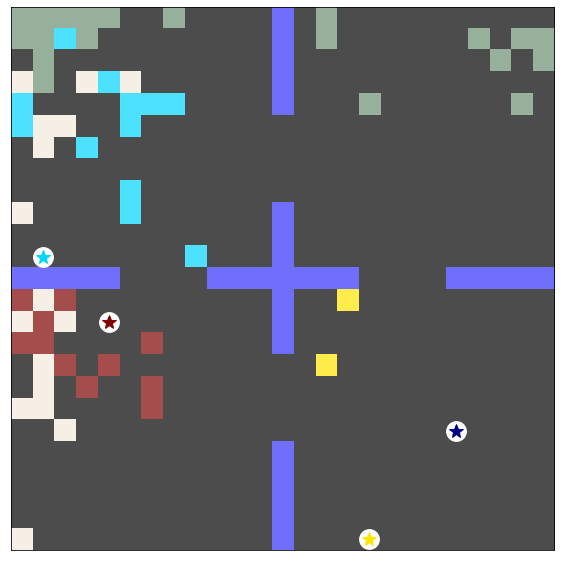

In [16]:
play_random_episode(env, plot_every=100)

We see four agents (indicated by a circled __\*__) that move around in the 2-dimensional world. Light brown cells contain Stone, green cells contain Wood. Each agent can build Houses, indicated by corresponding colored cells. Water tiles (blue squares), which prevent movement, divide the map into four quadrants.

Note: this is showing the same information as the image at the top of the tutorial -- it just uses a much more simplistic rendering.

# Visualize using dense logging

Environments built with Foundation provide a couple tools for logging. Perhaps the most useful are **dense logs**. When you reset the environment, you can tell it to create a dense log for the new episode. This will store Agent states at each point in time along with any Component-specific dense log information (say, about builds, trades, etc.) that the Components provide. In addition, it will periodically store a snapshot of the world state.

We provide a few plotting tools that work well with the type of environment showcased here.

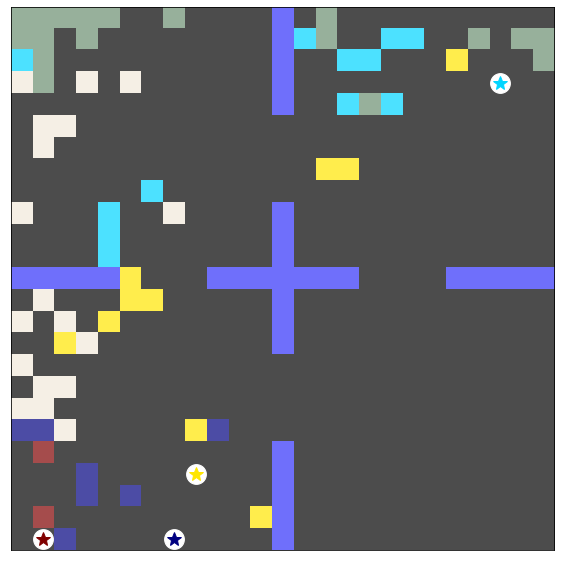

In [17]:
# Play another episode. This time, tell the environment to do dense logging
play_random_episode(env, plot_every=100, do_dense_logging=True)

# Grab the dense log from the env
dense_log = env.previous_episode_dense_log

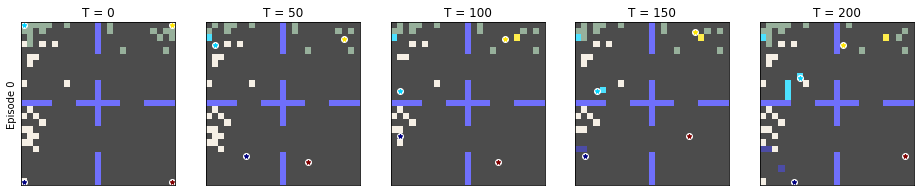

In [18]:
# Show the evolution of the world state from t=0 to t=200
fig = plotting.vis_world_range(dense_log, t0=0, tN=200, N=5)

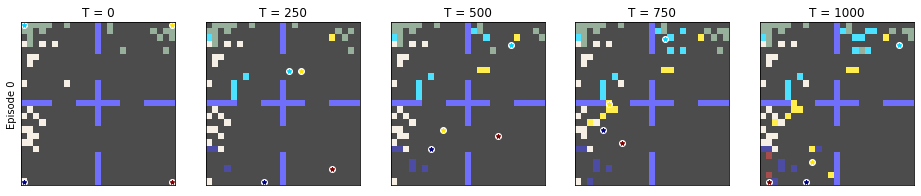

In [19]:
# Show the evolution of the world state over the full episode
fig = plotting.vis_world_range(dense_log, N=5)

_______________:_ Agent  0 _____|_ Agent  1 _____|_ Agent  2 _____|_ Agent  3 ____
Cost (Wood)    :   6.06 (n= 35) |   5.98 (n= 49) |   6.37 (n= 52) |   5.96 (n= 25)
Cost (Stone)   :   6.54 (n= 41) |   5.81 (n= 62) |   5.57 (n= 58) |   5.50 (n= 26)

Income (Wood)  :   5.54 (n= 28) |   6.27 (n= 60) |   6.08 (n= 50) |   6.52 (n= 23)
Income (Stone) :   5.63 (n= 51) |   5.66 (n= 53) |   6.36 (n= 50) |   5.73 (n= 33)
Income (Build) :  13.27 (n=  7) |  16.47 (n= 12) |  11.33 (n= 10) |  22.25 (n=  2)


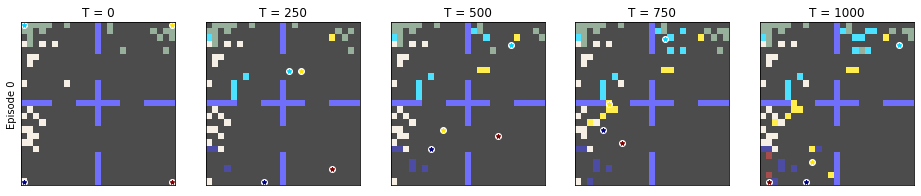

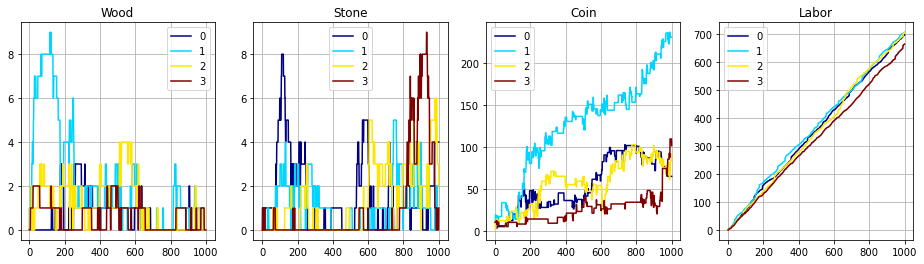

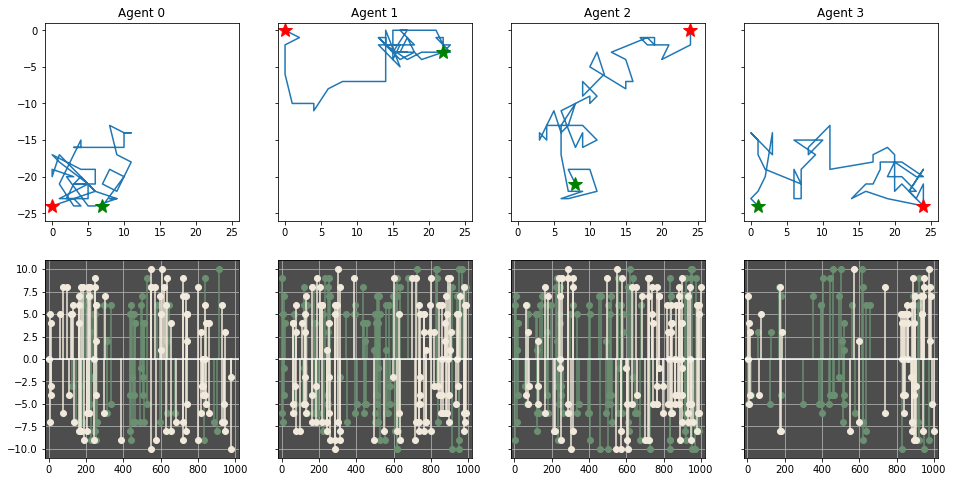

In [20]:
# Use the "breakdown" tool to visualize the world state, agent-wise quantities, movement, and trading events
plotting.breakdown(dense_log);

# Next

Now that you've seen how to interact with the simulation and generate episodes, try the next tutorial ([economic_simulation_advanced.ipynb](https://github.com/salesforce/ai-economist/blob/master/tutorials/economic_simulation_advanced.ipynb)) that explains how the simulation is composed of low-level Components and Entities. This structure enables flexible extensions of the economic simulation.